#### Import python files from another directory
In order to reuse code written in .py files you need to import them.
If they are from a distant folder, rather than copy-paste it into the current folder, you can write:

In [1]:
import sys
sys.path.append("../../ex02/template") # This goes up twice in the directories tree (hence in labs)
                                       # then goes down to ex02/template where your files from lab 2 are.

you can now import your desired files, for example, we can import grid_search.py with:

In [2]:
import grid_search        # You then need to call your functions using grid_search.function_name()
import grid_search as gs  # You then need to call your functions using gs.function_name()
from grid_search import * # You can call any functions of the file with function_name()

# Let's try to call generate_w from grid_search.py:
w0, w1 = generate_w(5)
print(w0, w1)

[-100.  -25.   50.  125.  200.] [-150.  -75.    0.   75.  150.]


As you can see we are now able to call functions from the grid_search.py file.

In [3]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from gradient_descent import *
from test_utils import test
%load_ext autoreload
%autoreload 2

# 1 Least squares and linear basis functions models
## 1.1 Least squares

In [4]:

def least_squares(y, tx):
    """Calculate the least squares solution.
       returns mse, and optimal weights.
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
        mse: scalar.
    """
    w=np.linalg.solve(tx.T@tx, tx.T@y)
    return compute_loss(y,tx,w), w


In [5]:
y=np.array([0.1,0.2])
tx=np.array([[2.3, 3.2], [1., 0.1]])
least_squares(y, tx)
#(array([ 0.21212121, -0.12121212]), 8.666684749742561e-33)


(8.666684749742561e-33, array([ 0.21212121, -0.12121212]))

### You can test your implementation here

In [6]:
losses,ws=gradient_descent(y,tx,(1,1),10000,1e-2)
print(losses[-1],ws[-1])

5.041580000760354e-28 [ 0.21212121 -0.12121212]


In [7]:
test(least_squares)
# NB:
# 
# Due to precision issues, 
# the output might not be exactly the same 
# even if you have implemented the right code.
#
# For example, the mse output expected to be
# 8.666684749742561e-33,
# but you might get some other small number
# close to zero.
#
# In this case,
# Failing the test doesn't necessarily means
# your implementation is wrong.:) 

Could not find any tests for least_squares


### Load the data
Here we will reuse the dataset `height_weight_genders.csv` from previous exercise section to check the correctness of your implementation. Please compare it with your previous result.

In [8]:
def test_your_least_squares():
    """
    # this code should compare the optimal weights obtained 
    # by least squares vs. grid search
    """
    height, weight, gender = load_data_from_ex02(sub_sample=False, add_outlier=False)
    x, mean_x, std_x = standardize(height)
    y, tx = build_model_data(x, weight)
    print("Least squares:\n", least_squares(y,tx))
    losses,ws=gradient_descent(y,tx,(1,1),10000,1e-2)
    print("Gradient descent:\n", losses[-1],ws[-1])

Test it here

In [9]:
test_your_least_squares()

Least squares:
 (15.385887868829407, array([73.293922  , 13.47971243]))
Gradient descent:
 15.385887868829407 [73.293922   13.47971243]


## 1.2 Least squares with a linear basis function model
Start from this section, we will use the dataset `dataEx3.csv`.

### Implement polynomial basis functions

In [10]:
# load dataset
x, y = load_data()
print("shape of x {}".format(x.shape))
print("shape of y {}".format(y.shape))

shape of x (50,)
shape of y (50,)


In [11]:
def build_poly(x, degree):
    """polynomial basis functions for input data x, for j=0 up to j=degree.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        degree: integer.
        
    Returns:
        poly: numpy array of shape (N,d+1)
        
    >>> build_poly(np.array([0.0, 1.5]), 2)
    array([[1.  , 0.  , 0.  ],
           [1.  , 1.5 , 2.25]])
    """
    N=x.shape[0]
    answ=np.ones((degree+1,N))
    for i in range(1,degree+1):
        answ[i,]=answ[i-1,]*x
    return answ.T

In [12]:
test(build_poly)

✅ Your `build_poly` passed 1 tests.


Let us play with polynomial regression. Note that we will use your implemented function `compute_mse`. Please copy and paste your implementation from exercise02.

In [13]:
from plots import *
def polynomial_regression():
    """Constructing the polynomial basis function expansion of the data,
       and then running least squares regression."""
    # define parameters
    degrees = [1, 3, 7, 12]
    
    # define the structure of the figure
    num_row = 2
    num_col = 2
    f, axs = plt.subplots(num_row, num_col)

    for ind, degree in enumerate(degrees):
        phix_d = build_poly(x,degree)
        loss,weights=least_squares(y,phix_d)
        rmse=np.sqrt(2*loss)
        print("Processing {i}th experiment, degree={d}, rmse={loss}".format(
              i=ind + 1, d=degree, loss=rmse))
        # plot fit
        plot_fitted_curve(
            y, x, weights, degree, axs[ind // num_col][ind % num_col])
    plt.tight_layout()

    plt.show()

Run polynomial regression

Processing 1th experiment, degree=1, rmse=0.47187607963421874
Processing 2th experiment, degree=3, rmse=0.2585827766773747
Processing 3th experiment, degree=7, rmse=0.2496587036090758
Processing 4th experiment, degree=12, rmse=0.24614764022485994


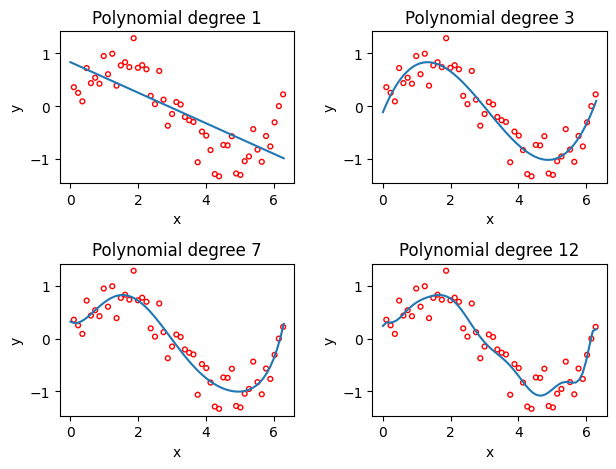

In [14]:
polynomial_regression()

Your results should look like this:

![alt text](visualize_polynomial_regression.png)

# 2 Evaluating model predication performance

Let us show the train and test splits for various polynomial degrees. First of all, please fill in the function `split_data()`

In [15]:
def split_data(x, y, ratio, seed=1):
    """
    split the dataset based on the split ratio. If ratio is 0.8 
    you will have 80% of your data set dedicated to training 
    and the rest dedicated to testing. If ratio times the number of samples is not round
    you can use np.floor. Also check the documentation for np.random.permutation,
    it could be useful.
    
    Args:
        x: numpy array of shape (N,), N is the number of samples.
        y: numpy array of shape (N,).
        ratio: scalar in [0,1]
        seed: integer.
        
    Returns:
        x_tr: numpy array containing the train data.
        x_te: numpy array containing the test data.
        y_tr: numpy array containing the train labels.
        y_te: numpy array containing the test labels.
        
    >>> split_data(np.arange(13), np.arange(13), 0.8, 1)
    (array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]), array([ 2,  3,  4, 10,  1,  6,  0,  7, 12,  9]), array([ 8, 11,  5]))
    """
    # set seed
    np.random.seed(seed)
    indx=np.random.permutation(x.shape[0])
    lim=int(np.floor(ratio*x.shape[0]))
    tr_idx, te_idx=indx[:lim], indx[lim:]
    return x[tr_idx],x[te_idx],y[tr_idx],y[te_idx]
    

In [16]:
test(split_data)

✅ Your `split_data` passed 1 tests.


Then, test your `split_data` function below.

In [17]:
def train_test_split_demo(x, y, degree, ratio, seed):
    """polynomial regression with different split ratios and different degrees.
    
    Returns:
      x_tr: numpy array
      x_te: numpy array
      y_tr: numpy array
      y_te: numpy array
      weights: weights from the least squares optimization"""
    x_tr,x_te,y_tr,y_te=split_data(x,y,ratio,seed)
    x_tr_d=build_poly(x_tr,degree)
    x_te_d=build_poly(x_te,degree)
    loss,w=least_squares(y_tr,x_tr_d)
    rmse_tr=np.sqrt(2*loss)
    rmse_te=np.sqrt(2*compute_loss(y_te,x_te_d,w)) 
    print("proportion={p}, degree={d}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
          p=ratio, d=degree, tr=rmse_tr, te=rmse_te))
    return x_tr,x_te,y_tr,y_te,w


Demo time

proportion=0.9, degree=1, Training RMSE=0.494, Testing RMSE=0.181
proportion=0.9, degree=3, Training RMSE=0.264, Testing RMSE=0.206
proportion=0.9, degree=7, Training RMSE=0.254, Testing RMSE=0.220
proportion=0.9, degree=12, Training RMSE=0.242, Testing RMSE=0.250
proportion=0.7, degree=1, Training RMSE=0.516, Testing RMSE=0.352
proportion=0.7, degree=3, Training RMSE=0.249, Testing RMSE=0.308
proportion=0.7, degree=7, Training RMSE=0.227, Testing RMSE=0.333
proportion=0.7, degree=12, Training RMSE=0.223, Testing RMSE=0.330
proportion=0.5, degree=1, Training RMSE=0.455, Testing RMSE=0.531
proportion=0.5, degree=3, Training RMSE=0.239, Testing RMSE=0.296
proportion=0.5, degree=7, Training RMSE=0.232, Testing RMSE=0.284
proportion=0.5, degree=12, Training RMSE=0.205, Testing RMSE=1.709
proportion=0.1, degree=1, Training RMSE=0.428, Testing RMSE=0.534
proportion=0.1, degree=3, Training RMSE=0.085, Testing RMSE=0.460
proportion=0.1, degree=7, Training RMSE=0.000, Testing RMSE=1.966
proport

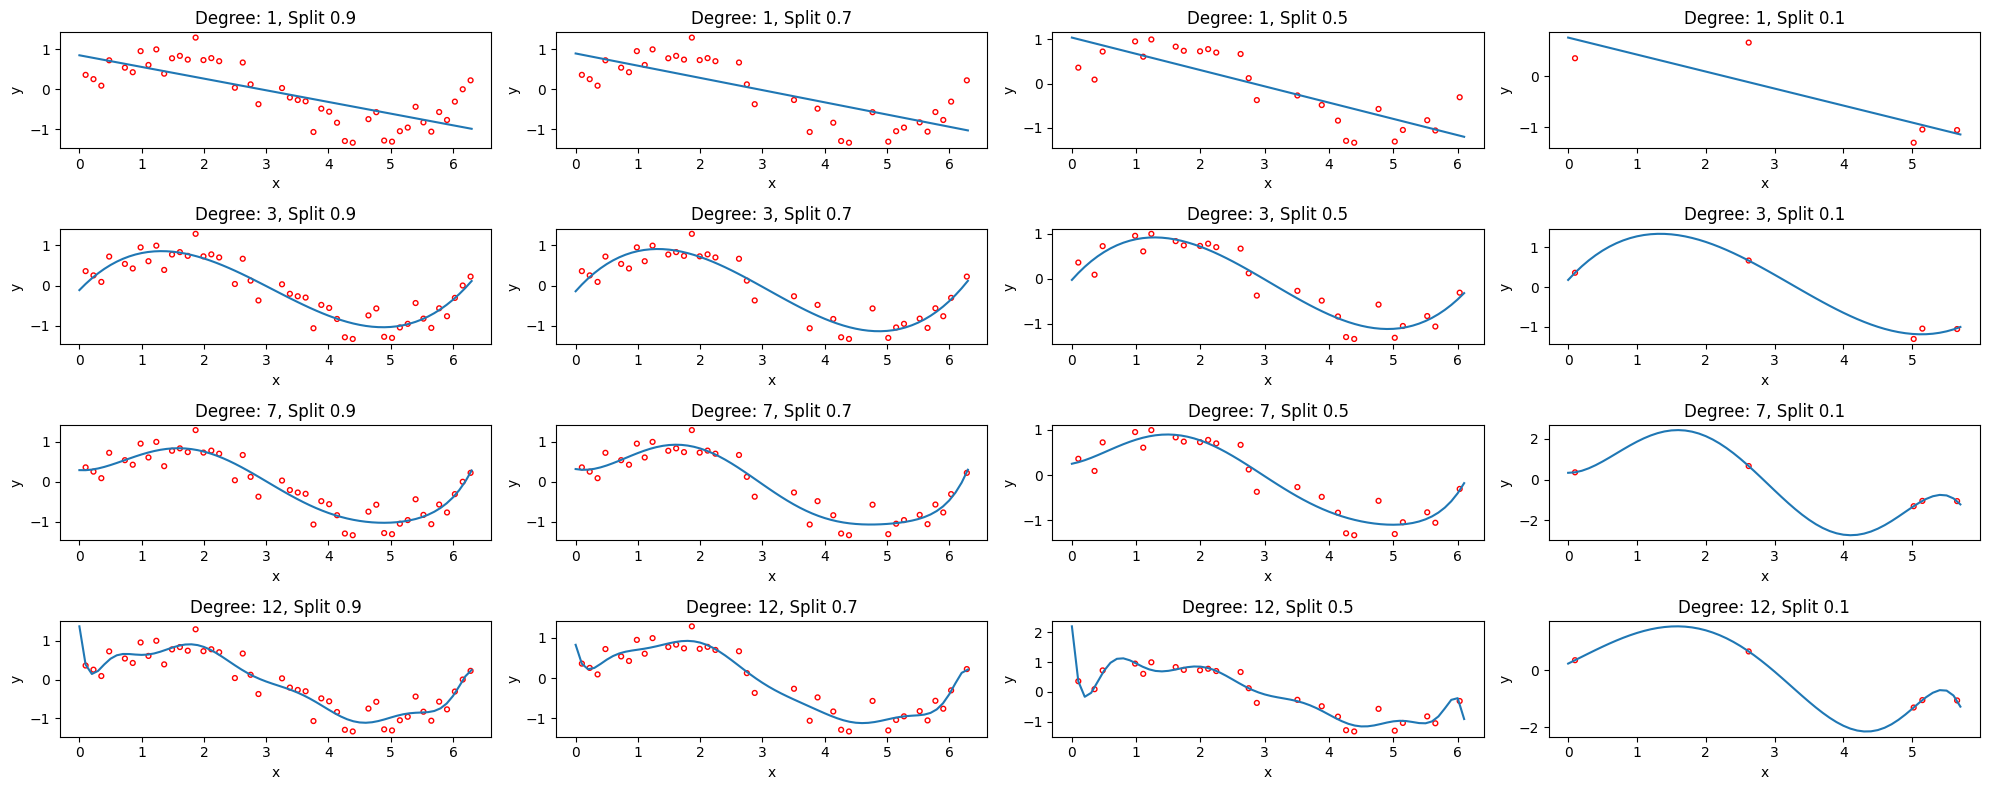

In [18]:
seed = 6
degrees = [1, 3, 7, 12]
split_ratios = [0.9, 0.7, 0.5, 0.1]

# define the structure of the figure
num_row = 4
num_col = 4
axs = plt.subplots(num_row, num_col, figsize=(20,8))[1]

for ind, split_ratio in enumerate(split_ratios):
    for ind_d, degree in enumerate(degrees):
        x_tr, x_te, y_tr, y_te, w = train_test_split_demo(x, y, degree, split_ratio, seed)
        plot_fitted_curve(
            y_tr, x_tr, w, degree, axs[ind_d][ind % num_col])
        axs[ind_d][ind].set_title(f'Degree: {degree}, Split {split_ratio}')
plt.tight_layout()


Your graph should look like this:

![alt text](split_demo.png)

# Ridge Regression
Please fill in the function below.

In [32]:
def ridge_regression(y, tx, lambda_):
    """implement ridge regression.
    
    Args:
        y: numpy array of shape (N,), N is the number of samples.
        tx: numpy array of shape (N,D), D is the number of features.
        lambda_: scalar.
    
    Returns:
        w: optimal weights, numpy array of shape(D,), D is the number of features.
    """
    w=np.linalg.solve(tx.T@tx+lambda_*2*tx.shape[0]*np.identity(tx.shape[1]), tx.T@y)
    return w

In [33]:
test(ridge_regression)

Could not find any tests for ridge_regression


In [34]:
def ridge_regression_demo(x, y, degree, ratio, seed):
    """ridge regression demo."""
    # define parameter
    lambdas = np.logspace(-5, 0, 15)

    x_tr,x_te,y_tr,y_te=split_data(x,y,ratio,seed)
    x_tr_d=build_poly(x_tr,degree)
    x_te_d=build_poly(x_te,degree)

    rmse_tr = []
    rmse_te = []
    for ind, lambda_ in enumerate(lambdas):
        w=ridge_regression(y_tr,x_tr_d,lambda_)
        rmse_tr.append(np.sqrt(2*compute_loss(y_tr,x_tr_d,w)))
        rmse_te.append(np.sqrt(2*compute_loss(y_te,x_te_d,w)))
        print("proportion={p}, degree={d}, lambda={l:.3f}, Training RMSE={tr:.3f}, Testing RMSE={te:.3f}".format(
               p=ratio, d=degree, l=lambda_, tr=rmse_tr[ind], te=rmse_te[ind]))
    plot_train_test(rmse_tr, rmse_te, lambdas, degree)

Demo time

proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.338
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.337
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.336
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.227, Testing RMSE=0.335
proportion=0.5, degree=7, lambda=0.000, Training RMSE=0.228, Testing RMSE=0.334
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.228, Testing RMSE=0.333
proportion=0.5, degree=7, lambda=0.001, Training RMSE=0.229, Testing RMSE=0.329
proportion=0.5, degree=7, lambda=0.003, Training RMSE=0.230, Testing RMSE=0.319
proportion=0.5, degree=7, lambda=0.007, Training RMSE=0.232, Testing RMSE=0.302
proportion=0.5, degree=7, lambda=0.016, Training RMSE=0.237, Testing RMSE=0.283
proportion=0.5, degree=7, lambda=0.037, Training RMSE=0.246, Testing RMSE=0.276
proportion=0.5, degree=7, lambda=0.085, Training RMSE=0.264, Testing RMSE=0.298
proportion=0.5, degree=7, lambda=0.193, 

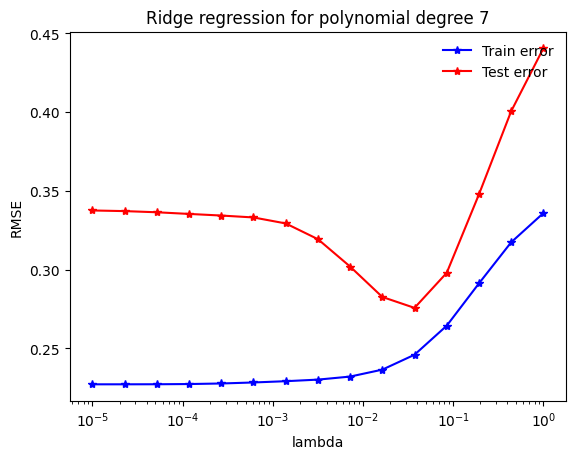

In [38]:
seed = 56
degree = 7
split_ratio = 0.5
ridge_regression_demo(x, y, degree, split_ratio, seed)


Your plot should look like:

![alt text](ridge_regression.png)